In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

In [2]:
def GamaFunct(X,gama):
    return (1+gama)*np.power(X,gama)-gama*np.power(X,(1+gama))

In [3]:
def CalcUptake(Biomass,gama):
    XRange = range(1001)
    XUptake = [float(X)/1000.0 for X in XRange]
    XBiomass = [GamaFunct(X,gama) for X in XUptake]
    Pairs = pd.DataFrame(index=XBiomass,data=XUptake,columns=['XUptake'])
    ind = (np.abs(np.subtract(XBiomass,Biomass))).argmin()
    return Pairs.iloc[ind][0]

In [63]:
def MakeBasePlot(Xstart,XnonF,Xmax,Bmax,gama,Es,Er,PlotMax):
    Bscaller = float(Xmax)/float(Bmax) * 1.4
    Xs = Xstart + XnonF
    NegativeAxis = range(0,(int(PlotMax)+1)*-1,-1)
    PositiveAxis = range(0,(int(PlotMax)+1),1) 
    RelativeUptake = [min(1,float(X)/float(Xmax)) for X in PositiveAxis]
    Beta = [(1+gama)*np.power(X,gama)-gama*np.power(X,(1+gama)) for X in RelativeUptake]
    Biomass = [float(Bmax) * Bscaller * X for X in Beta]
    FieldAvailableN = np.multiply([X - Xstart - XnonF for X in NegativeAxis],Es)
    FieldUptakeN = [min(Xmax,np.multiply(X,Er))for X in PositiveAxis]
    FieldUstar =  [min(1,float(X*-1)/float(Xmax)) for X in FieldAvailableN]
    FieldBstar = [GamaFunct(X,gama) for X in FieldUstar]
    FieldBiomass = [float(Bmax) * Bscaller * X for X in FieldBstar]
    Graph = plt.figure(figsize=(12,12))
    Soil = plt.plot(NegativeAxis,FieldAvailableN,color='brown',linewidth=3)
    Root = plt.plot(FieldUptakeN,NegativeAxis,color='orange',linewidth=3)
    Shoot = plt.plot(PositiveAxis,Biomass,color='green',linewidth=3)
    Field = plt.plot(NegativeAxis,FieldBiomass,color='blue',linewidth=3)
    Grid1 = plt.plot([0,0],[-(PlotMax*2),PlotMax*2],color='k')
    Grid2 = plt.plot([-(PlotMax*2),PlotMax*2],[0,0],color='k')
    plt.ylim(-(PlotMax*1.15),(Bmax * Bscaller * 1.15))
    plt.xlim(-(PlotMax*1.15),PlotMax*1.15)
    plt.yticks([-(PlotMax),0,Bmax * Bscaller],[PlotMax,0,Bmax],fontsize=16)
    plt.xticks([-PlotMax,0,PlotMax],[PlotMax,0,PlotMax],fontsize=16)
    plt.text(PlotMax*0.25,-PlotMax*1.25,'Crop N Uptake (kg/ha)',fontsize=18)
    plt.text(-PlotMax*1.25,-PlotMax*0.25,'Soil N Available (kg/ha)',fontsize=18,rotation=90)
    plt.text(-PlotMax*0.9,-PlotMax*1.25,'Fertiliser N Inputs (kg/ha)',fontsize=18)
    plt.text(-PlotMax*1.25,PlotMax*0.75,'Crop Biomass (kg/ha)',fontsize=18,rotation=90)
    plt.text(-PlotMax*1.1,PlotMax,'Field',fontsize=20)
    plt.text(-PlotMax*1.1,-PlotMax*1.1,'Soil',fontsize=20)
    plt.text(PlotMax*0.9,-PlotMax*1.1,'Roots',fontsize=20)
    plt.text(PlotMax*0.85,PlotMax,'Canopy',fontsize=20)

In [13]:
def PlotObs(Data,Xmax,Bmax,Symbol,Colour):
    Bscaller = float(Xmax)/float(Bmax) * 1.4
    ObsSoil = plt.plot(Data.Nfert * -1,Data.ObsNAvl * -1,Symbol,color=Colour,markersize = 9)
    ObsRoot = plt.plot(Data.ObsUptake,Data.ObsNAvl * -1,Symbol,color=Colour,markersize = 9)
    ObsShoot = plt.plot(Data.ObsUptake,Data.ObsBiom * Bscaller,Symbol,color=Colour,markersize = 9)
    ObsField = plt.plot(Data.Nfert * -1,Data.ObsBiom * Bscaller,Symbol,color=Colour,markersize = 9)

In [6]:
def PlotWalk(InputN,Xmax,Xstart,XnonF,gama,Es,Er,Bact,Bmax,line):
    Xs = Xstart + XnonF 
    Xact = CalcUptake(float(Bact)/float(Bmax),gama) * Xmax
    Bscaller = float(Xmax)/float(Bmax) * 1.4
    WalkCoords = pd.DataFrame(index = [0,1,2,3,4],columns=['X','Y'])
    WalkCoords.ix[0,'Y'] = 0                                   #Startpoint
    WalkCoords.ix[0,'X'] = -InputN      #Fertiliserinputs                        
    WalkCoords.ix[1,'X'] = WalkCoords.ix[0,'X']
    WalkCoords.ix[1,'Y'] = -(InputN + Xstart + XnonF)*Es  # Available N
    WalkCoords.ix[2,'Y'] = WalkCoords.ix[1,'Y']
    WalkCoords.ix[2,'X'] = min(np.abs(WalkCoords.ix[2,'Y']*Er),Xact)  # Untake N
    WalkCoords.ix[3,'X'] = WalkCoords.ix[2,'X']
    Ustar = float(WalkCoords.ix[3,'X'])/Xmax
    Bstar = GamaFunct(Ustar,gama)
    if Ustar < 1:
        WalkCoords.ix[3,'Y'] = Bstar * Bmax * Bscaller   #Biomass 
    else:
        WalkCoords.ix[3,'Y'] = Bmax * Bscaller           #Biomass
    WalkCoords.ix[4,'X'] = WalkCoords.ix[1,'X']
    WalkCoords.ix[4,'Y'] = WalkCoords.ix[3,'Y']
    
    WalkPlot = plt.plot(WalkCoords.X,WalkCoords.Y,line,color='k')

In [62]:
def PlotFits(Xmax,Xstart,XnonF,Bmax,Bact,gama,Es,Er,Line,PlotMax):
    NegativeAxis = range(0,(PlotMax+1)*-1,-1)
    PositiveAxis = range(0,(PlotMax+1),1)
    
    Xact = CalcUptake(float(Bact)/float(Bmax),gama) * Xmax
    Bscaller = float(Xmax)/float(Bmax) * 1.4
    Ustar = [min(1,float(X)/float(Xmax)) for X in PositiveAxis]
    Bstar = [(1+gama)*np.power(X,gama)-gama*np.power(X,(1+gama)) for X in Ustar]
    FitBiomass = [float(Bmax) * Bscaller * X for X in Bstar]
    FitAvailableN = np.multiply([X-Xstart-XnonF for X in NegativeAxis],float(Es))
    FitUptakeN = [min(Xact,np.multiply(X*-1,float(Er)))for X in FitAvailableN]
    FitUstar =  [min(1,float(X)/float(Xmax)) for X in FitUptakeN]
    FitBstar = [GamaFunct(X,gama) for X in FitUstar]
    FitFieldBiomass = [float(Bmax) * Bscaller * X for X in FitBstar]
    
    FitSoil = plt.plot(NegativeAxis,FitAvailableN,Line,color='brown',linewidth=3)
    FitRoot = plt.plot(FitUptakeN,FitAvailableN,Line,color='orange',linewidth=3)
    FitShoot = plt.plot(PositiveAxis,FitBiomass,Line,color='green',linewidth=3)
    FitField = plt.plot(NegativeAxis,FitFieldBiomass,Line,color='blue',linewidth=3)

In [9]:
MaizeData = pd.read_pickle('MaizeData.pkl')
MaizeMeans = MaizeData.groupby(level=['Irrig','Fert'],axis=0).mean()
MaizeSD = MaizeData.groupby(level=['Irrig','Fert'],axis=0).std()

In [10]:
MaizeMeans

Plot  Block     ObsY  ObsBiom  Nfert     ObsNAvl   ObsUptake
Irrig Fert                                                               
Full  000N  11.25    2.5  10995.0  20208.0    0.0  179.142235  161.449451
      075N  11.75    2.5  12803.0  24427.0   75.0  230.517831  208.752922
      250N  14.00    2.5  15209.0  28339.0  250.0  327.836900  281.167581
Nil   000N  12.75    2.5   3464.0   7677.0    0.0  131.836657   53.288483
      075N  13.25    2.5   5264.0  11051.0   75.0  229.943587   88.213740
      250N  12.00    2.5   6202.0  11928.0  250.0  331.103314   93.022908

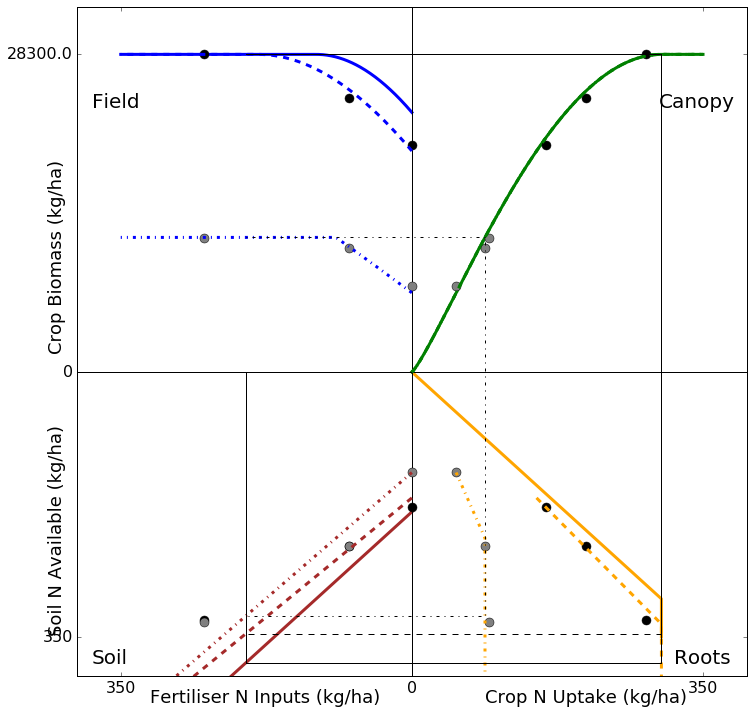

In [64]:
PlotMax = 350
Xmax = 300.0
Bmax = 28300.0
gama = 1.2

#Create axes and plot potentials
# MakeBasePlot(Xstart,XnonF,Xmax,Bmax,gama,Es,Er,PlotMax):
MakeBasePlot(47,138,Xmax,Bmax,gama,1,1,PlotMax)

#Put observed values on plot
#PlotObs(Data,Xmax,Bmax,Symbol,Colour):
PlotObs(MaizeMeans.ix['Full',:],Xmax,Bmax,'o','k')
PlotObs(MaizeMeans.ix['Nil',:],Xmax,Bmax,'o','grey')

#Fit identities to observed values
#PlotFits(Xmax,Xstart,XnonF,Bmax,Bact,gama,Es,Er,Line,PlotMax):
PlotFits(Xmax,47,138,Bmax,28300,gama,0.9,0.9,'--',PlotMax)
PlotFits(Xmax,47,93,Bmax,12000,gama,0.95,0.4,'-.',PlotMax)

#Plot the coordinates to walk around the identity at a given level of input
#PlotWalk(InputN,Xmax,Xstart,XnonF,gama,Es,Er,Bact,Bmax,line):
PlotWalk(200,Xmax,47,138,gama,1.0,1.0,Bmax,Bmax,'-')
PlotWalk(200,Xmax,47,138,gama,0.9,0.9,28300,Bmax,'--')
PlotWalk(200,Xmax,47,93,gama,0.95,0.4,12000,Bmax,'-.')

In [7]:
CocksFoot = pd.read_pickle('CocksFoot.pkl')

In [19]:
CocksFoot.ix[:15,:]

,Irrigation,Nfert,ObsNAvl,ObsUptake,ObsBiom
Irrigation,,,,,
dry,dry,19.928258,24.187750,14.449377,39.465687
dry,dry,10.210593,11.501525,3.458918,11.197294
dry,dry,13.898541,14.607853,0.709646,2.896627
dry,dry,14.152279,14.628297,0.674911,1.911184
dry,dry,18.563208,20.329609,6.111575,15.109984
dry,dry,23.719165,26.677117,11.552557,27.588177
dry,dry,37.313433,42.215600,33.033252,70.226138
dry,dry,44.809559,48.175628,31.862318,73.631620
dry,dry,35.103115,38.480311,9.729990,23.955449


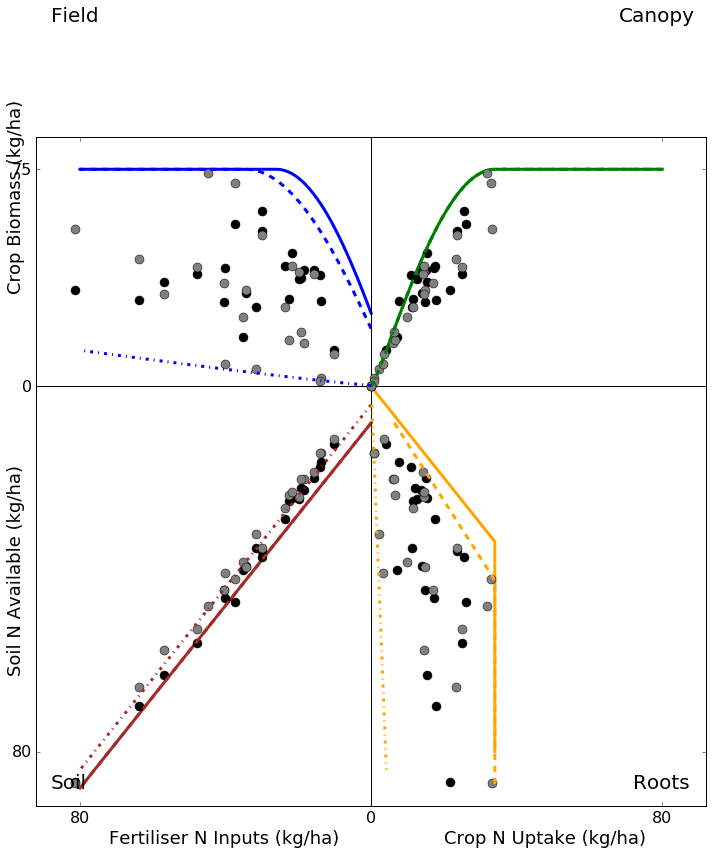

In [72]:
PlotMax = 80
Xmax = 34.0
Bmax = 75
gama = 1.2

#Create axes and plot potentials
# MakeBasePlot(Xstart,XnonF,Xmax,Bmax,gama,Es,Er,PlotMax):
MakeBasePlot(0,8,Xmax,Bmax,gama,1,1,PlotMax)

#Put observed values on plot
#PlotObs(Data,Xmax,Bmax,Symbol,Colour):
PlotObs(CocksFoot.ix['irr',:],Xmax,Bmax,'o','k')
PlotObs(CocksFoot.ix['dry',:],Xmax,Bmax,'o','grey')

#Fit identities to observed values
#PlotFits(Xmax,Xstart,XnonF,Bmax,Bact,gama,Es,Er,Line,PlotMax):
PlotFits(Xmax,0,8,Bmax,75,gama,1,0.8,'--',PlotMax)
PlotFits(Xmax,0,4,Bmax,75,gama,1,0.05,'-.',PlotMax)

# #Plot the coordinates to walk around the identity at a given level of input
# #PlotWalk(InputN,Xmax,Xstart,XnonF,gama,Es,Er,Bact,Bmax,line):
# PlotWalk(200,Xmax,47,138,gama,1.0,1.0,Bmax,Bmax,'-')
# PlotWalk(200,Xmax,47,138,gama,0.9,0.9,28300,Bmax,'--')
# PlotWalk(200,Xmax,47,93,gama,0.95,0.4,12000,Bmax,'-.')